In [1]:
import os
print(os.listdir("../input"))

import warnings
warnings.filterwarnings('ignore')

[]


# Project Overview
This project aims to classify questions retrieved from the Stack Overflow database based on the language they are related to. In order to accomplish this, the data will first be retrieved using an SQL query. Following, natural langauge processing(NLP) techniques and feature engineering will be used in conjunction with a deep learning neural network in an attempt to classify the questions. This will be my first kernel here on Kaggle and I'm really excited to share what I've accomplished. 

**I wished to include more techniques such as k-fold cross validation and use more data, however due to the 13 GB memory limit, I was unable to. However, I just want to thank Kaggle for allowing me to use a GPU compatible with TensorFlow as my own laptop runs on an AMD GPU.*  

# Retrieving Data from database using SQL

In [2]:
import bq_helper
from bq_helper import BigQueryHelper
# https://www.kaggle.com/sohier/introduction-to-the-bq-helper-package
stackOverflow = bq_helper.BigQueryHelper(active_project="bigquery-public-data",
                                   dataset_name="stackoverflow")

Using Kaggle's public dataset BigQuery integration.


In [3]:
stack_db = BigQueryHelper("bigquery-public-data", "stackoverflow")
stack_db.list_tables()

Using Kaggle's public dataset BigQuery integration.


['badges',
 'comments',
 'post_history',
 'post_links',
 'posts_answers',
 'posts_moderator_nomination',
 'posts_orphaned_tag_wiki',
 'posts_privilege_wiki',
 'posts_questions',
 'posts_tag_wiki',
 'posts_tag_wiki_excerpt',
 'posts_wiki_placeholder',
 'stackoverflow_posts',
 'tags',
 'users',
 'votes']

In [4]:
stack_db.head("posts_questions", num_rows=5)

,id,title,body,accepted_answer_id,answer_count,comment_count,community_owned_date,creation_date,favorite_count,last_activity_date,last_edit_date,last_editor_display_name,last_editor_user_id,owner_display_name,owner_user_id,post_type_id,score,tags,view_count
0,23280293,Jasper report data summary,<p>I am trying to create a report to display a...,23373319.0,1,2,None,2014-04-24 21:33:46.787000+00:00,NaN,2014-05-01 13:37:52.027000+00:00,2014-05-01 13:37:52.027000+00:00,,321731,,1214943,1,0,filter|jasper-reports|summary,266
1,5787776,A worthy developer-friendly alternative to PayPal,"<p>I understand payments are a tricky thing, b...",NaN,8,9,None,2011-04-26 08:28:37.397000+00:00,40.0,2013-03-19 01:57:09.860000+00:00,2013-03-19 01:57:09.860000+00:00,,772853,,50841,1,95,paypal|payment-gateway|payment|credit-card,10505
2,51899406,Why does adding a destructor (even empty) brea...,<p>I am making a class to store a reference to...,NaN,1,0,None,2018-08-17 16:17:18.367000+00:00,NaN,2018-08-17 17:08:03.690000+00:00,2018-08-17 17:08:03.690000+00:00,,241631,,3662349,1,3,c++|c++11|templates|perfect-forwarding,53
3,29219176,"Java Math.pow(x,2.0) vs Math.pow(x,2.0000001) ...",<p>I am trying to compare performance of <code...,29232947.0,1,8,None,2015-03-23 19:55:25.693000+00:00,2.0,2016-07-19 21:48:22.440000+00:00,2016-07-19 21:48:22.440000+00:00,,2753863,,2739693,1,5,java|performance,427
4,45545053,rioBufferWrite function Redis updating position,"<p>When I am reading the code of <a href=""http...",NaN,0,6,None,2017-08-07 10:46:21.007000+00:00,NaN,2017-08-07 10:57:45.507000+00:00,2017-08-07 10:57:45.507000+00:00,,8051589,,7700616,1,1,c|redis,30


In [5]:
stack_db.table_schema("posts_questions")

,name,type,mode,description
0,id,INTEGER,REQUIRED,None
1,title,STRING,NULLABLE,None
2,body,STRING,NULLABLE,None
3,accepted_answer_id,INTEGER,NULLABLE,None
4,answer_count,INTEGER,NULLABLE,None
5,comment_count,INTEGER,NULLABLE,None
6,community_owned_date,TIMESTAMP,NULLABLE,None
7,creation_date,TIMESTAMP,NULLABLE,None
8,favorite_count,INTEGER,NULLABLE,None
9,last_activity_date,TIMESTAMP,NULLABLE,None


For this project, we will be retrieving the title, body, tags, and views from the posts_questions table. Shown below is the query and command used to retrieve this information. The query ensures the retrieved data is tagged as either a python, java, javascript, sql, or R based question. Additionally, the length of the body was limited to only 1000 characters in length, and only 7500 results were retreived. These constraints were placed in order to prevent memory overflow. 

In [6]:
query1 = """
         SELECT
             title,
             body as question,
             tags as labels, 
             view_count as views
         FROM
             `bigquery-public-data.stackoverflow.posts_questions`
         WHERE 
             (tags LIKE '%python%' OR
             tags LIKE '%java%' OR 
             tags LIKE '%sql%' OR 
             tags LIKE '%|r|%' OR
             tags LIKE 'r|%') AND
             LENGTH(body) < 1000
         LIMIT
             7500;
         """

questions_df = stackOverflow.query_to_pandas(query1)

# Data Preprocessing

In [7]:
#import necessary packages for analysis 
import nltk
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')

First, we must split the tags. From the header, we can observe that the tags are seperated by the character '|' and are split accordingly.

In [8]:
questions_df['labels'] = questions_df['labels'].str.split('|')

Next, we find the programming language tags and limit the questions to only those involving a single programming langauge. This is done for simplicity. 


In [9]:
def return_tags(labels):
    langauges = [lang for lang in labels if lang in ['python','java','sql','r','javascript']] 
    return langauges

In [10]:
questions_df['labels'] = questions_df['labels'].apply(return_tags)

In [11]:
# Find rows that contain only a single tag
processed_df = questions_df[(questions_df['labels'].apply(len) > 0) & (questions_df['labels'].apply(len) < 2)]  

In [12]:
#verify that only questions with a single language tag are included
processed_df.head()

,title,question,labels,views
0,"Java Math.pow(x,2.0) vs Math.pow(x,2.0000001) ...",<p>I am trying to compare performance of <code...,[java],427
1,Dropins Drobox plugin error,<p>I have added this script on my page:</p>\n\...,[javascript],88
2,Python: KeyError but both key and value exists,<p>I'm fetching information from the opendota ...,[python],106
3,How to get reCaptcha HTML content from cross d...,<p>Im trying to get reCaptcha HTML content whi...,[javascript],333
4,Setting the width of a pagination depending on...,<p>I am trying to set the width of a paginatio...,[javascript],73


In [13]:
processed_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6204 entries, 0 to 7499
Data columns (total 4 columns):
title       6204 non-null object
question    6204 non-null object
labels      6204 non-null object
views       6204 non-null int64
dtypes: int64(1), object(3)
memory usage: 242.3+ KB


In [14]:
# In order to properly work with these labels, we must convert them from lists into strings.
def lst_to_str(lst):
    unpacked = ''.join(lst)
    return unpacked

processed_df.loc[:,'labels'] = processed_df.loc[:,'labels'].apply(lst_to_str)

#processed_df.describe()
#processed_df.groupby('labels').describe()

# Data Visualization

Now we will begin exploring the data to determine what features to extract and train our neural network on. The first features that come to mind are the number of views each question received as well as the length of each question. For example, perhaps due to the complexity of a language over another, the questions pertaining to that langauge may be longer in length. Additionally, perhaps due to popularity of a certain langauge over another, questions related to one langauge may have more views over another. These features were the first to come to mind due to already being numeric within the dataframe.  

First, we will explore the distribution of the number of view each question got based on what language they were related to. 

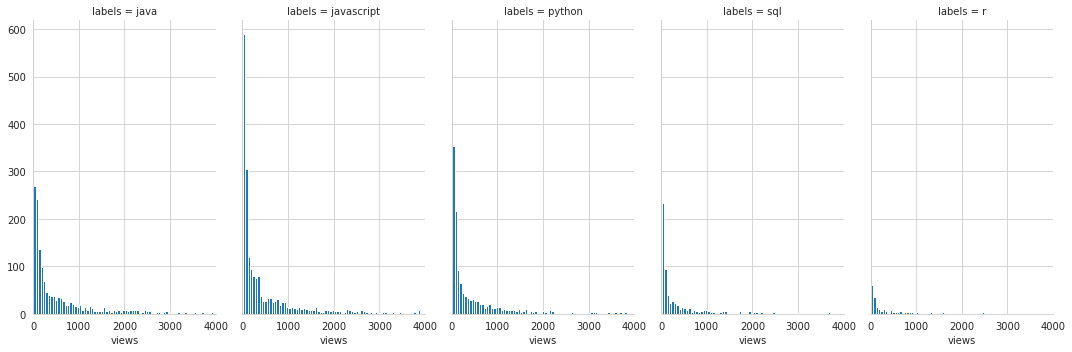

In [15]:
grid = sns.FacetGrid(processed_df[processed_df['views'] < 4000], col = 'labels', height = 5, aspect = 0.6)
grid.map(plt.hist, 'views', bins = 75)
axes = grid.axes
axes[0,1].set_xlim([0,4000])

plt.tight_layout()

It appears that most languages are distrbuted evenly across number of views. There were some outliers amongst the languages however, I removed them for easier visualization. 

Now we will analyze the length of each question. This will be done by first applying the `len` function to the `question` column and placing the results into a new column labeled `length_of_question`.

In [16]:
processed_df.loc[:,'length_of_question'] = processed_df.loc[:,'question'].apply(len)

In [17]:
# verify the procedure worked.
processed_df.head(2)

,title,question,labels,views,length_of_question
0,"Java Math.pow(x,2.0) vs Math.pow(x,2.0000001) ...",<p>I am trying to compare performance of <code...,java,427,327
1,Dropins Drobox plugin error,<p>I have added this script on my page:</p>\n\...,javascript,88,461


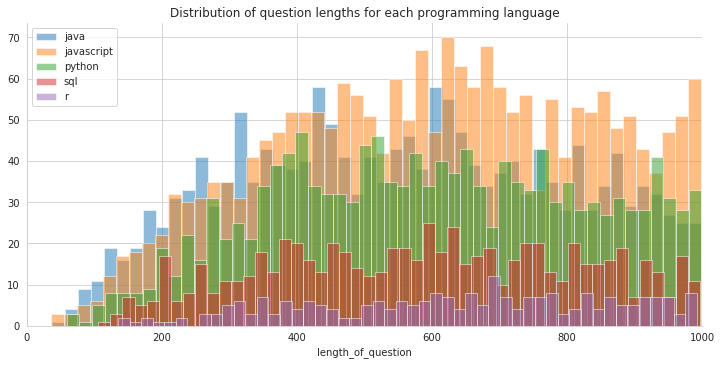

In [18]:
# Plot the length of each question based on what language they were written in
grid = sns.FacetGrid(processed_df, hue = 'labels', height = 5, aspect = 2)
grid.map(plt.hist, 'length_of_question', bins = 50, alpha = 0.5)
axes = grid.axes

axes[0,0].set_title('Distribution of question lengths for each programming language')
axes[0,0].set_xlim([0,1000])
axes[0,0].legend()

Clearly, no obvious trends are visible. The heigth of the bars indicate how many questions had a length within that range, and are affected by how many questions are about each language. From the plot, the questions are fairly similar in length throughout. 
 
 ## Extracting Features from Code
Now that we know that didn't work we have to find different features to train our neural network on. 
Some background: In typical stack overflow questions, questions are asked by first summarizing the problem, and then including code blocks describing what the user has tried. 
We know that each language has syntactic difference, for example, in R, values are assigned using a less than sign along with a dash('<-'), whereas in python, values are assigned using the equals sign('='). What if we honed in on these differences? Additional differences that come to mind are the number of brackets used, the number of arithmetic operators, and even punctuation such as periods or slashes. 

Okay we have a plan of action, how do we actually implement this? Well first we have to parse the question strings for the code blocks. These questions are written in html and as such we can use a html parser to retrieve those code blocks. 

In [19]:
# An example of a question posted on stack overflow. Notice the html syntax and code delimiters.
processed_df['question'][2]

'<p>I\'m fetching information from the opendota API. I\'ve previously taken out a .csv list with approx. 160 match_ids which I want some more information from and then append certain values to a list. </p>\n\n<p>With the code below, While looping through the list I receive a KeyError.</p>\n\n<pre><code>for x in finallist:\n    matchinfo = requests.get("https://api.opendota.com/api/matches/{}".format(x)).json()["match_id"]\n    print(matchinfo)\n</code></pre>\n\n<p>The KeyError is raised on a certain ID\'s, but if I use the code below, I get no KeyError and I see the information.</p>\n\n<pre><code>matchspec = requests.get("https://api.opendota.com/api/matches/4184421518").json()[\'match_id\']\nmatchspec\n</code></pre>\n\n<p>So through this, 4184421518 prints information, but in the loop it stops at that ID and a couple more IDs below that. Why do I receive a KeyError in the for loop, but not when I specifically ask for the information? </p>'

In order to actually implement the html parser onto the question column of our dataframe, we must define a function that retrieves the code. 

In [20]:
import lxml.html

def find_code(html_str):
    final_list = []

    dom = lxml.html.fromstring(html_str)
    codes = dom.xpath('//code')

    for code in codes:
        final_list.append(code.text)
    
    final_list = ' '.join(final_list)
    return final_list 

In [21]:
processed_df.loc[:,'code'] = processed_df.loc[:,'question'].apply(find_code)

Now that we've applied our function and retrieved our code, we need to extract the features of that code. We will now define functions that retrieve these features and apply them to our newly created `code` column. 

In [22]:
def count_colons(txt):
    return txt.count(':')

def count_semicolons(txt):
    return txt.count(';')

def count_slashes(txt):
    return txt.count('/')
                                      
def count_cbrackets(txt):
    return txt.count('{') + txt.count('}')

def count_sbrackets(txt):
    return txt.count('[') + txt.count(']')

def count_quotes(txt):
    return txt.count('"') + txt.count("'")

def count_arithmetic(txt):
    return txt.count('<') + txt.count('>') + txt.count('-') + txt.count('+') 

def count_period(txt):
    return txt.count('.')

In [23]:
processed_df.loc[:,'colon count'] = processed_df.loc[:,'code'].apply(count_colons)
processed_df.loc[:,'semicolon count'] = processed_df.loc[:,'code'].apply(count_semicolons)
processed_df.loc[:,'slash count'] = processed_df.loc[:,'code'].apply(count_slashes)
processed_df.loc[:,'cbracket count'] = processed_df.loc[:,'code'].apply(count_cbrackets)
processed_df.loc[:,'sbracket count'] = processed_df.loc[:,'code'].apply(count_sbrackets)
processed_df.loc[:,'quote count'] = processed_df.loc[:,'code'].apply(count_quotes)
processed_df.loc[:,'operator count'] = processed_df.loc[:,'code'].apply(count_arithmetic)
processed_df.loc[:,'period count'] = processed_df.loc[:,'code'].apply(count_period)

In [24]:
# Verify the functions worked.
processed_df.head()

,title,question,labels,views,length_of_question,code,colon count,semicolon count,slash count,cbracket count,sbracket count,quote count,operator count,period count
0,"Java Math.pow(x,2.0) vs Math.pow(x,2.0000001) ...",<p>I am trying to compare performance of <code...,java,427,327,"pow(x,2.0) pow(x,2.0000001) 2.0 -Xint",0,0,0,0,0,0,1,3
1,Dropins Drobox plugin error,<p>I have added this script on my page:</p>\n\...,javascript,88,461,"<script type=""text/javascript"" src=""https://ww...",3,0,15,0,0,8,6,12
2,Python: KeyError but both key and value exists,<p>I'm fetching information from the opendota ...,python,106,932,for x in finallist:\n matchinfo = requests....,3,0,10,2,4,8,0,9
3,How to get reCaptcha HTML content from cross d...,<p>Im trying to get reCaptcha HTML content whi...,javascript,333,957,,0,0,0,0,0,0,0,0
4,Setting the width of a pagination depending on...,<p>I am trying to set the width of a paginatio...,javascript,73,495,,0,0,0,0,0,0,0,0


Now that we have verified that the functions worked as intended, we will use heatmaps to visualize the results, and potentially determine if there are any noticeable difference in each languages' syntax. 

Text(0.5, 1.0, 'R features heatmap')

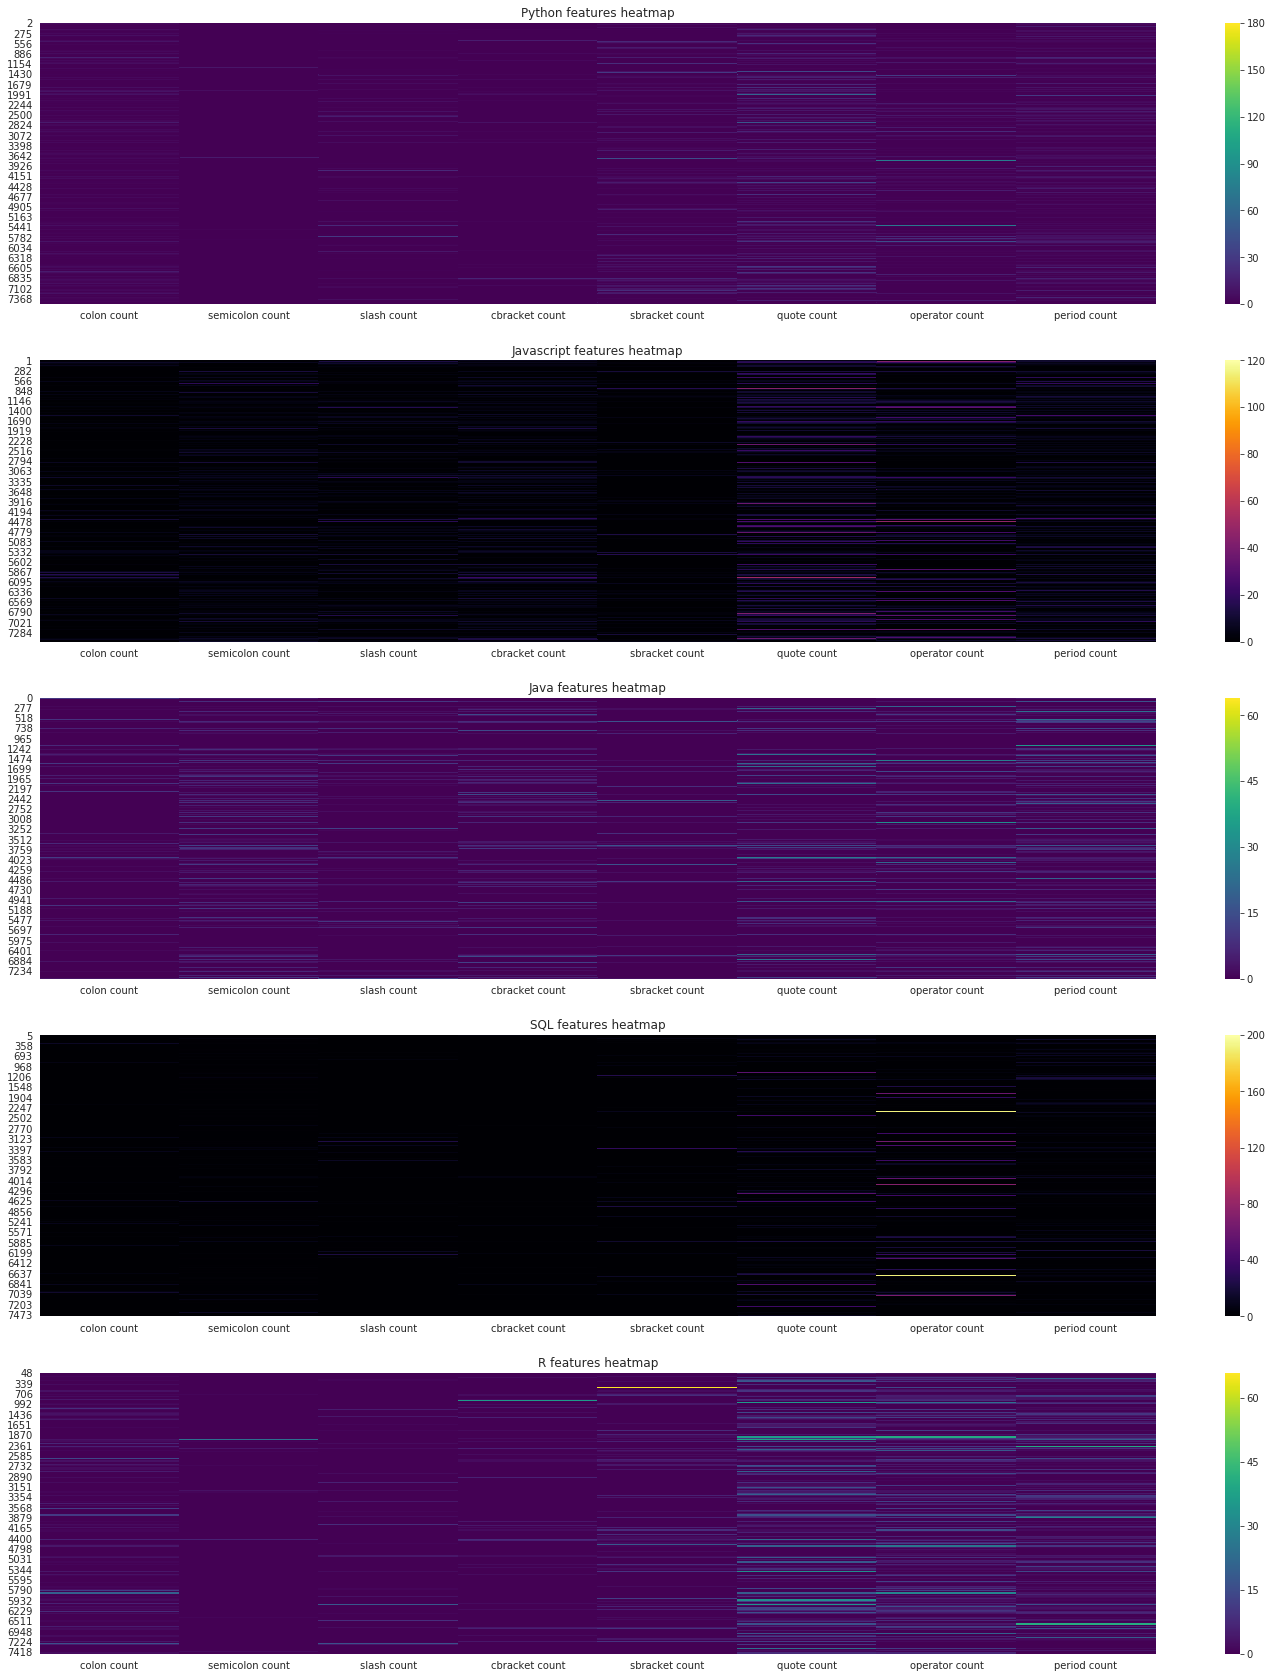

In [25]:
fig, axis = plt.subplots(figsize=(25,30), nrows = 5)

python_features = processed_df[processed_df['labels'] == 'python'].loc[:,'colon count':]
js_features = processed_df[processed_df['labels'] == 'javascript'].loc[:,'colon count':]
java_features = processed_df[processed_df['labels'] == 'java'].loc[:,'colon count':]
sql_features = processed_df[processed_df['labels'] == 'sql'].loc[:,'colon count':]
r_features = processed_df[processed_df['labels'] == 'r'].loc[:,'colon count':]

sql_features.head()

sns.heatmap(python_features, cmap = 'viridis', ax = axis[0])
axis[0].set_title('Python features heatmap')

sns.heatmap(js_features, cmap = 'inferno', ax = axis[1])
axis[1].set_title('Javascript features heatmap')

sns.heatmap(java_features, cmap = 'viridis', ax = axis[2])
axis[2].set_title('Java features heatmap')

sns.heatmap(sql_features, cmap = 'inferno', ax = axis[3])
axis[3].set_title('SQL features heatmap')

sns.heatmap(r_features, cmap = 'viridis', ax = axis[4])
axis[4].set_title('R features heatmap')


From these heatmaps, a couple of observations can be found:
* The square bracket count, quote count, operator count and period count occur the most frequently in python.
* For Javascript, quotes and operators clearly appear the most frequenctly.
* For Java, the occurrences of each special character is fairly even. 
* In SQL, these special characters rarely occur aside from arithmetic operatos. This is a largely due to SQL using white space and new lines to denote complete statements. 
* For R, quote counts, operator counts, and period counts occur most often. 

Many of these observations make sense, with knowledge of each language's syntactic difference. 
In order to get a complete overview, a heatmap displaying the total of of each special character grouped by their language is plotted. 

Text(0.5, 1.0, 'Syntactic Features of Programming Languages')

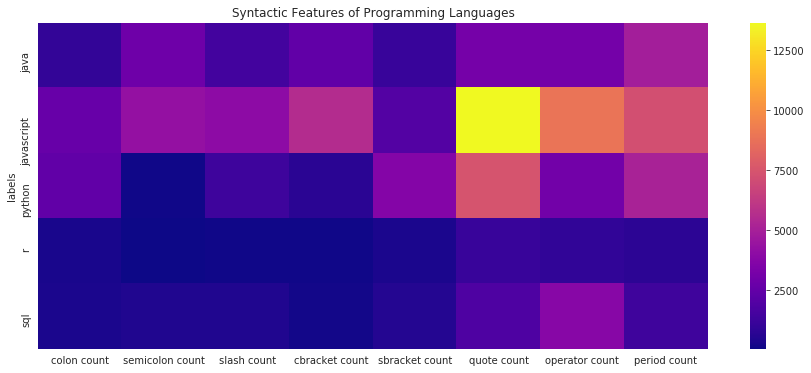

In [26]:
total_syntax_features = processed_df.groupby('labels').sum(axis=1).loc[:,'colon count':]

fig, aggregate_axis = plt.subplots(figsize=(15,6))
sns.heatmap(total_syntax_features, cmap = 'plasma', ax = aggregate_axis)
aggregate_axis.set_title('Syntactic Features of Programming Languages')

It must be noted that this heatmap is skewed based on how many of each type of question was retrieved by the SQL query. Nonetheless, some observations can still be made: 
* Amongst the special characters in both python and Java, periods occur quite often. This makes sense considering that both languages are object-oriented, where their methods are denonted by periods. 
* The quote count for javascript is extremely high. This is due to the fact that javascript is used in conjunction with HTML, in which text denoted by quotes occur more frequently. 

In order to remove the effects of the uneven retrieval of data from the SQL query, we will use sci-kit `preprocessing` library.

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype int64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


Text(0.5, 1.0, 'Normalized Code Features')

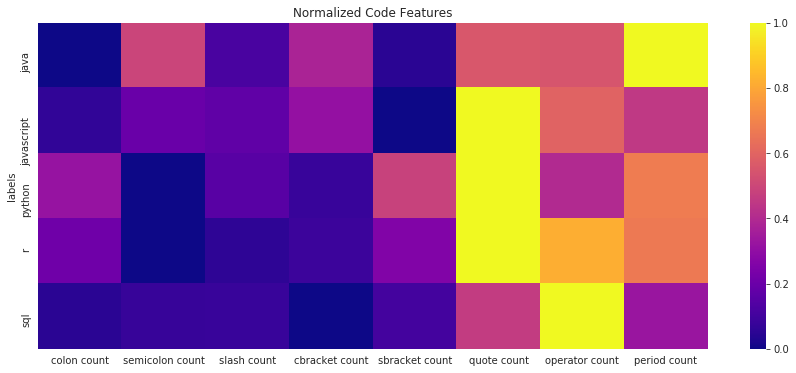

In [27]:
from sklearn.preprocessing import MinMaxScaler

min_max_scaler = MinMaxScaler()
total_syntax_features_scaled = pd.DataFrame(min_max_scaler.fit_transform(total_syntax_features.T), columns = total_syntax_features.index, index = total_syntax_features.columns)
total_syntax_features_scaled.head(10)

fig, axis_scaled = plt.subplots(figsize=(15,6))
sns.heatmap(total_syntax_features_scaled.T, cmap = 'plasma', ax = axis_scaled)
axis_scaled.set_title('Normalized Code Features')

Here we are better able to visualize which features are the most prominent amongst their respective languages. 

## Extracting Features from Content

Now that we've extracted features from the `code` column, we can begin processing the actual contents of the questions and their respective titles. In order to do this we will use an html parser to extract the text from those columns, and then use a `CountVectorizer` to convert those words into a sparse matrix to serve as inputs to our neural network. This is also known as converting text into a "bag-of-words" and is a common natural language processing technique. 

To do this, we will parse the question for any text. For this project, we will only be using english text. We will also exclude numbers and stopwords. 

In [28]:
from bs4 import BeautifulSoup

def find_text(html_str):
    full_text = ''

    parsedContent = BeautifulSoup(html_str, 'html.parser')

    text = parsedContent.findAll('p')
    
    for paragraph in text:
        full_text = full_text + paragraph.getText()
        
    return full_text    

In [29]:
import re 
import string
from nltk.corpus import stopwords 

stop_words = stopwords.words()
translation_table = dict.fromkeys(map(ord, string.punctuation), None)

def remove_punc_and_stopwords(full_text):
    cleaned_text = full_text.translate(translation_table)
    word_lst = re.findall('[a-zA-Z]+', cleaned_text)
    return " ".join(word_lst)

In [30]:
def clean_html_text(text):
    final_text = find_text(text)
    bag_of_words = remove_punc_and_stopwords(final_text)
    return bag_of_words

In [31]:
processed_df.head(2)

,title,question,labels,views,length_of_question,code,colon count,semicolon count,slash count,cbracket count,sbracket count,quote count,operator count,period count
0,"Java Math.pow(x,2.0) vs Math.pow(x,2.0000001) ...",<p>I am trying to compare performance of <code...,java,427,327,"pow(x,2.0) pow(x,2.0000001) 2.0 -Xint",0,0,0,0,0,0,1,3
1,Dropins Drobox plugin error,<p>I have added this script on my page:</p>\n\...,javascript,88,461,"<script type=""text/javascript"" src=""https://ww...",3,0,15,0,0,8,6,12


In [32]:
# Remove digits and special characters from title column. Note that it does not require an html parser.
processed_df.loc[:,'title'] = processed_df.loc[:,'title'].apply(remove_punc_and_stopwords)

In [33]:
# Extract the text of the question column, and remove digits and special characters.
processed_df.loc[:,'question'] = processed_df.loc[:,'question'].apply(clean_html_text)

In [34]:
# Observe that there is no longer any punctuation or digits in the questions.
processed_df.head(10)

,title,question,labels,views,length_of_question,code,colon count,semicolon count,slash count,cbracket count,sbracket count,quote count,operator count,period count
0,Java Mathpowx vs Mathpowx performance,I am trying to compare performance of powx and...,java,427,327,"pow(x,2.0) pow(x,2.0000001) 2.0 -Xint",0,0,0,0,0,0,1,3
1,Dropins Drobox plugin error,I have added this script on my pagebut in the ...,javascript,88,461,"<script type=""text/javascript"" src=""https://ww...",3,0,15,0,0,8,6,12
2,Python KeyError but both key and value exists,Im fetching information from the opendota API ...,python,106,932,for x in finallist:\n matchinfo = requests....,3,0,10,2,4,8,0,9
3,How to get reCaptcha HTML content from cross d...,Im trying to get reCaptcha HTML content which ...,javascript,333,957,,0,0,0,0,0,0,0,0
4,Setting the width of a pagination depending on...,I am trying to set the width of a pagination d...,javascript,73,495,,0,0,0,0,0,0,0,0
5,Get next value not null in the same column in SQL,I have a SQL query which return the lines with...,sql,509,635,,0,0,0,0,0,0,0,0
6,Can a HTMLJavaScript Windows Store app run in ...,I am about to begin developing an application ...,javascript,120,374,,0,0,0,0,0,0,0,0
7,Java input string,Im having difficulties returning a user input ...,java,583,574,"System.out.println(""please enter a digit: "");\...",3,9,2,0,0,6,0,15
9,Using INSERT after a THEN is this possible,Im sorry new to this siteMS SQL Server R That ...,sql,102,576,Select CASE when sysname <> system_user Then i...,2,0,0,4,0,6,3,0
10,Eclipse and GWT desing mode,I am Working with GWT and eclipse I am facing ...,java,87,160,,0,0,0,0,0,0,0,0


We will now implement the `CountVectorizer` and covert the text into a "bag-of-words". We will store the results into new dataframes to be concatenated with the rest of our neural network inputs later.

In [35]:
from sklearn.feature_extraction.text import CountVectorizer

cv_title = CountVectorizer().fit(processed_df['title'])
vectorized_title = cv_title.transform(processed_df['title'])
vectorized_title_df = pd.DataFrame(vectorized_title.toarray(), columns = cv_title.get_feature_names())
#vectorized_title_df.head()
#vectorized_title_df.info()

In [36]:
cv_question = CountVectorizer().fit(processed_df['question'])
vectorized_question = cv_question.transform(processed_df['question'])
vectorized_question_df = pd.DataFrame(vectorized_question.toarray(), columns = cv_question.get_feature_names())
#vectorized_question_df.head()
#vectorize_questions_df.info()

Clearly, the values of `'length_of_question'`, and `'views'` will far outnumber the ones and zeros of the countvectorized columns, as well as the code syntax totals. This can heavily skew the result of our neural network. In order to avoid this we will use sci-kit learn's StandardScaler to scale the values within an appropriate range. I chose to scale each section seperately within their "category' because I do not know which features have the most impact in determining what language the question pertains to. Perhaps, the language is more heavily dicatacted by the code_features than the content? As such, keep them scaled within their respective categories. 

In [37]:
from sklearn.preprocessing import StandardScaler

In [38]:
views_and_length = processed_df.loc[:,['views','length_of_question']]
code_features = processed_df.loc[:,'colon count':]

# Scale the views column
ss_view_length = StandardScaler()
scaled_views_and_length = ss_view_length.fit_transform(views_and_length.astype(float)) 
scaled_views_and_length_df = pd.DataFrame(scaled_views_and_length, columns = views_and_length.columns)

# Scale the code features
ss_code = StandardScaler()
scaled_code_features = ss_code.fit_transform(code_features.astype(float))
scaled_code_features_df = pd.DataFrame(scaled_code_features, columns = code_features.columns)

# Concatenate the results into complete preprocessed dataframe.
final_scaled_vectorized_df = pd.concat([vectorized_title_df, vectorized_question_df, scaled_views_and_length_df, scaled_code_features_df], axis = 1)
final_scaled_vectorized_df.head(2)

,ab,abbreviated,ability,able,aborted,about,above,absent,absolute,abstract,abstractreplyproducingmessagehandler,abstracttablemodel,accented,accents,accept,accepted,accepting,accepts,acces,accesing,access,accessdecisionmanager,accessed,accessibility,accessing,accessors,accidental,according,accordion,account,accounts,accretion,accuracy,accurate,accurately,ace,achieve,acking,acquire,across,...,zeros,zhao,zig,ziggurat,zilch,zindex,zindexed,zip,zipcodes,zipfile,zips,zipurl,zoho,zombie,zone,zoneif,zones,zoo,zoom,zoomed,zoomin,zooming,zooms,zoomworks,zq,zsh,zso,zurb,zz,zzzzbov,views,length_of_question,colon count,semicolon count,slash count,cbracket count,sbracket count,quote count,operator count,period count
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-0.085684,-1.116386,-0.419075,-0.501507,-0.382164,-0.457175,-0.275284,-0.544229,-0.237914,-0.023595
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-0.095023,-0.539831,0.733551,-0.501507,4.507731,-0.457175,-0.275284,0.446207,0.302990,1.685196


In [39]:
final_scaled_vectorized_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6204 entries, 0 to 6203
Columns: 30183 entries, ab to period count
dtypes: float64(10), int64(30173)
memory usage: 1.4 GB


# Building the Deep Learning Network
We will not begin constructing our neural network. We will do this useing Keras, which is a framework for Google's TensorFlow library. Notice that from the `.info()` method above, we observe that our input dataframe has 30,183 entries. This will play a role in determining the number of neurons each hidden layer contains as well as how many hidden layers we have. I chose the number of neurons to gradually decrease until the expected five outputs(one for each classification). Additionally, for the hidden layers the activation function was chosen to be `'relu'` and the output activation function was chosen to be `'softmax'`, which is standard for single label classification problems such as this.   

**note, I attempted to use k-fold cross validation, however due to memory constraints, I was unable to.* 

In [40]:
from keras.models import Sequential
from keras.layers import Dense, Dropout

classifier = Sequential()
classifier.add(Dense(units = 10000,
                     input_shape = (30183,),
                     kernel_initializer = 'glorot_uniform',
                     activation = 'relu'
                    )
              )
classifier.add(Dropout(0.45))
classifier.add(Dense(units = 3300,
                     kernel_initializer = 'glorot_uniform',
                     activation = 'relu'
                    )
              ) 
classifier.add(Dropout(0.25))
classifier.add(Dense(units = 1150,
                     kernel_initializer = 'glorot_uniform',
                     activation = 'relu'
                    )
              )    
classifier.add(Dropout(0.45))
classifier.add(Dense(units = 400,
                     kernel_initializer = 'glorot_uniform',
                     activation = 'relu'
                    )
              )
classifier.add(Dropout(0.25))
classifier.add(Dense(units = 130,
                     kernel_initializer = 'glorot_uniform',
                     activation = 'relu'
                    )
              )
classifier.add(Dropout(0.25))
classifier.add(Dense(units = 50,
                     kernel_initializer = 'glorot_uniform',
                     activation = 'relu'
                    )
              )
classifier.add(Dropout(0.25))
classifier.add(Dense(units = 25,
                     kernel_initializer = 'glorot_uniform',
                     activation = 'relu'
                    )
              )
classifier.add(Dense(units = 5,
                     kernel_initializer = 'glorot_uniform',
                     activation = 'softmax'
                    )
              )

classifier.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In order to properly train our data, we must split our data into a training set and a test set. Again, we use sci-kit learn's `train-test-split` function. We choose `X` to be our preprocessed data and our `y` to be the labels. When setting y, we must remember to dummy encode the labels because the labels are categorical. 

In [41]:
from sklearn.model_selection import train_test_split

X = final_scaled_vectorized_df
y = pd.get_dummies(processed_df['labels'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [42]:
#training the data. A batch size and number of epochs were chosen to remain within the memory constraints.
classifier.fit(X_train, y_train, batch_size = 42, epochs = 75)

Instructions for updating:
Use tf.cast instead.
Epoch 1/75
4342/4342 [==============================] - 32s 7ms/step - loss: 1.2971 - acc: 0.4148
Epoch 2/75
4342/4342 [==============================] - 16s 4ms/step - loss: 0.7492 - acc: 0.7158
Epoch 3/75
4342/4342 [==============================] - 16s 4ms/step - loss: 0.3467 - acc: 0.8922
Epoch 4/75
4342/4342 [==============================] - 16s 4ms/step - loss: 0.1901 - acc: 0.9353
Epoch 5/75
4342/4342 [==============================] - 16s 4ms/step - loss: 0.1255 - acc: 0.9678
Epoch 6/75
4342/4342 [==============================] - 16s 4ms/step - loss: 0.0961 - acc: 0.9820
Epoch 7/75
4342/4342 [==============================] - 16s 4ms/step - loss: 0.0620 - acc: 0.9896
Epoch 8/75
4342/4342 [==============================] - 16s 4ms/step - loss: 0.0623 - acc: 0.9901
Epoch 9/75
4342/4342 [==============================] - 16s 4ms/step - loss: 0.0584 - acc: 0.9915
Epoch 10/75
4342/4342 [==============================] - 16s 4ms/step 

In [43]:
# store the predictions. 
predictions = classifier.predict(X_test)

In [44]:
# Retrieve labels by taking the max value in each row and convert it to a 1, effectively 'labeling' the resutls.
from sklearn.preprocessing import LabelBinarizer

labels = np.argmax(predictions, axis = -1)
lb = LabelBinarizer()
labeled_predictions = lb.fit_transform(labels)

# Evaluation
In order to evaluate the results of the network, we will use the sci-kit learn's `classification_report` and `confusion matrix`. The classification report will give the precision, recall, and f1-score of the results of an neural network, while the confusion matrix will indicate how many rows were properly classified.

In [45]:
from sklearn.metrics import classification_report

print(classification_report(y_test.values, labeled_predictions))

              precision    recall  f1-score   support

           0       0.84      0.71      0.77       515
           1       0.85      0.82      0.84       619
           2       0.74      0.84      0.79       436
           3       0.43      0.50      0.46        72
           4       0.77      0.89      0.82       220

   micro avg       0.79      0.79      0.79      1862
   macro avg       0.73      0.75      0.74      1862
weighted avg       0.80      0.79      0.79      1862
 samples avg       0.79      0.79      0.79      1862



In [46]:
from sklearn.metrics import confusion_matrix

print('Confusion matrix for Java')
print(confusion_matrix(y_test.loc[:,'sql'], labeled_predictions[:,0]))
print('\n')

print('Confusion matrix for Javascript')
print(confusion_matrix(y_test.loc[:,'javascript'], labeled_predictions[:,1]))
print('\n')

print('Confusion matrix for Python')
print(confusion_matrix(y_test.loc[:,'python'], labeled_predictions[:,2]))
print('\n')

print('Confusion matrix for R')
print(confusion_matrix(y_test.loc[:,'r'], labeled_predictions[:,3]))
print('\n')

print('Confusion matrix for SQL')
print(confusion_matrix(y_test.loc[:,'sql'], labeled_predictions[:,4])) 


Confusion matrix for Java
[[1214  428]
 [ 217    3]]


Confusion matrix for Javascript
[[1154   89]
 [ 109  510]]


Confusion matrix for Python
[[1298  128]
 [  70  366]]


Confusion matrix for R
[[1742   48]
 [  36   36]]


Confusion matrix for SQL
[[1583   59]
 [  25  195]]


# Conclusion
Using some feature engineering and natural language processing techniques, I was able to train a neural network to classify questions from Stack Overflow based solely on their titles and content with a precision, recall, and f1-score of approximately 0.80! I'm quite happy with those results. In the future, I would like to experiment with the activation functions, number of layers, optimizers, and even my own loss function. I would also love to figure out an algorithm to extract syntatic features of programming languages that aren't character based, features such as formatting or even style. Nonethless, I really enjoyed this project, and I'm excited to continue my journey into data science and machine learning!